<a href="https://colab.research.google.com/github/ciminilab/2022_Garcia-Fossa_submitted/blob/main/Basic_Protocol_2_Visualize_cells_and_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visualize random or representative cell in a given well and whole field of view images**

## Before running, click on **+ Copy to my Drive** to have your own copy of the notebook.

- **What are the inputs necessary to run this notebook?** You don't have to worry if you don't have your own data, you can use an example from our GitHub.

- **What if I wanna run this notebook with my own data?** 
 

1.  Before anything else, you need a table with feature information on the columns, and single-cell information on rows. We recommend to use CellProfiler outputs, since they will be in the same format;
2.   Then you need to mount this notebook on your Google Drive, so it can access your images and table;
3. Don't forget to change the Inputs on Section 2 to match your data's name and path.




        
## Steps:

1. Import libraries
2. Define inputs 
3. Import DataFrame and add columns
4. Choose the information to plot
5. Calculate correlations
6. Visualize!

  

# **1. Import libraries**

In [1]:
#@title Clone GitHub and pip install functions

#@markdown * This step will clone the GitHub repository presented on the Interpreting Image-Based Profiles paper. 


!git clone https://github.com/ciminilab/2022_Garcia-Fossa_submitted

%cd /content/2022_Garcia-Fossa_submitted/
!pip install ./utils

Cloning into '2022_Garcia-Fossa_submitted'...
remote: Enumerating objects: 601, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 601 (delta 52), reused 59 (delta 41), pack-reused 524
Receiving objects: 100% (601/601), 255.71 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Checking out files: 100% (421/421), done.
/content/2022_Garcia-Fossa_submitted
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./utils
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for utils: filename=utils-1.0-py3-n

In [2]:
#@title Pip install needed libraries and import libraries

#@markdown * This step will take about 5 minutes to run.

!pip install pyarrow 
!pip install git+https://github.com/cytomining/pycytominer
!pip install openpyxl
!pip install scikit-image
!pip install hdmedians
!pip install scikit-fda
!pip install GPy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cytomining/pycytominer to /tmp/pip-req-build-q2meuxaq
  Running command git clone -q https://github.com/cytomining/pycytominer /tmp/pip-req-build-q2meuxaq
     |████████████████████████████████| 35.4 MB 172 kB/s 
     |████████████████████████████████| 316 kB 39.3 MB/s 
  Created wheel for pycytominer: filename=pycytominer-0.2.0-py2.py3-none-any.whl size=259571094 sha256=6d5b5b917cc9b36cd561bcf19b67c850dacb4b501a4baad8053ffa481143d025
  Stored in directory: /tmp/pip-ephem-wheel-cache-rbonajel/wheels/27/b4/e1/4b6c06357f432818b8e1f57673e99dde8d3e36bd9f070b23ee
Successfully built pycytominer
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: p

In [3]:
#@title Import libraries

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.read_data import *
from utils.visualize_data import *
from utils.correlations import *
from sklearn.cluster import KMeans
from openpyxl import Workbook, load_workbook
import os
import pycytominer
from google.colab import files

# **2. Define inputs**



* Here we define the file_name, dataset_path and images_dir based on the path we have on our GitHub repository.

    -  **file_name** - name for a csv file
    -  **dataset_path** - path to file_name
    -  **images_dir** - path to images (can be our GitHub repo or your local directory to test with your own images)
    -  **box_size** - size of box in pixels for cropping a cell
    -  **channels** - list of channels you want to plot



In [4]:
file_name =  r"/BasicProtocols2_Example.zip"

dataset_path = r'/content/2022_Garcia-Fossa_submitted/basic_protocol_2/data'

images_dir = r"/content/2022_Garcia-Fossa_submitted/basic_protocol_2/images" #give the directory of where pictures are

box_size = 150

channels = ["DNA","ER","RNA","AGP","Mito"]

In [ ]:
#@title Run this cell only if you want to run with your own data instead the ones in our GitHub repo.

#@markdown * This cell will mount Colab on your own Google Drive, and ask for the inputs.

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

file_name_input =  input(r"Provide file_name:")
file_name = "/" + file_name_input

dataset_path_input = input(r"Provide the path to file_name:")
dataset_path = "/" + dataset_path_input

images_dir_input = input(r"Provide the path to your images:")
images_dir = "/" + images_dir_input

box_size_input = input("Size of the box to crop the cells, in pixels:")
box_size = int(box_size_input)

channels = [item for item in input("Provide a list of names for the channels you want to plot. Give them separated by space like: DNA RNA ER").split()]

# **3. Import file as DataFrame**

In [5]:
#open DataFrame
df = pd.read_csv(dataset_path+file_name, low_memory=False)

## **3.3 Create new column: join Compound + Concentration**
*   This will make it easier later if the user wants to plot compounds that has more than one tested concentration


In [6]:
col_generator(df)

Names of the compounds + concentration:  ['DMSO 0.00' 'XL888 10.00' 'ixabepilone 10.00' 'LY2334737 10.00'
 'LY2334737 1.11' 'docetaxel 10.00' 'cabazitaxel 10.00'
 'fiacitabine 10.00']


,Image_Metadata_Plate,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,Metadata_Well,Metadata_Concentration,Metadata_moa,Metadata_Compound,...,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,PathName_OrigMito,PathName_OrigAGP,PathName_OrigDNA,PathName_OrigRNA,PathName_OrigER,Metadata_Compound_Concentration
0,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.163522,-0.143627,653.073964,32.750634,NaN,NaN,NaN,NaN,NaN,DMSO 0.00
1,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.497862,0.346073,1979.191781,47.390839,NaN,NaN,NaN,NaN,NaN,DMSO 0.00
2,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.265209,-0.608686,2080.545903,48.469193,NaN,NaN,NaN,NaN,NaN,DMSO 0.00
3,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.545001,0.182150,1120.825549,52.805403,NaN,NaN,NaN,NaN,NaN,DMSO 0.00
4,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.211246,0.463527,1696.844459,78.116332,NaN,NaN,NaN,NaN,NaN,DMSO 0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,-1.126082,-0.815897,257.289705,2091.924182,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00
7573,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,0.500818,0.657768,1040.821322,2097.956493,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00
7574,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,0.987424,1.341672,1429.728495,2098.826344,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00
7575,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,0.639820,0.099569,1743.008311,2110.983646,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00


# **4. User's choice: choose to plot based on which metadata information**



*   You can plot all compounds (4.2) or choose to plot a few selected ones (4.3)



In [7]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [8]:
#@title 4.1 Choose metadata information
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Image_Metadata_Plate', 'Metadata_Well', 'Metadata_Concentration', 'Me…

In [9]:
#@title 4.1.1 Save dropdown choice

sort_by = dropdown_output
print(sort_by)

Metadata_Compound_Concentration


In [10]:
#@title 4.2 To plot ALL compounds/moa, run this cell


list_to_plot = [x for x in df[sort_by].unique().tolist()]

In [13]:
#@title 4.3 To plot SELECTED compounds/moa, run this cell
import ipywidgets as wid
options_dict = {
    x: wid.Checkbox(
        description=x, 
        value=False,
        style={"description_width":"0px"}
    ) for x in [x for x in df[sort_by].unique().tolist()]
}
ui = multi_checkbox_widget(options_dict)
out = wid.interactive_output(f, options_dict)
display(wid.HBox([ui, out]))

Output()

In [14]:
#@title 4.3.1 Save SELECTED compounds
list_to_plot = [widget.description for widget in ui.children[1].children if widget.value]
print(list_to_plot)

['DMSO 0.00', 'XL888 10.00', 'ixabepilone 10.00']


# **5. Calculate correlations**


* These are correlations calculated just as we see on Morpheus.
*   Using corr function, calculate Pearson correlation between the groups.  
*   In the first step, the data is grouped using pycytominer functions (pycytominer_operations), and then visualize confusion matrix using seaborn.

In [11]:
#@title Pycytominer operations. Return aggregated DataFrame
df_ag = pycytominer_operations(df, strata = sort_by, samples = "Metadata_Compound == 'DMSO'")
df_ag

Numbers of columns dropped after feature selection:  692


,Metadata_Compound_Concentration,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,...,Nuclei_Texture_SumVariance_ER_20_0,Nuclei_Texture_SumVariance_Mito_20_0,Nuclei_Texture_SumVariance_RNA_10_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,DMSO 0.00,0.495801,-0.172485,-0.067009,0.045589,-0.003348,0.166936,-0.243993,-0.031327,0.072429,...,0.216053,0.168286,0.102186,0.084981,0.230043,0.081219,0.097683,0.120058,0.046489,0.017629
1,LY2334737 1.11,0.437939,-0.203540,-0.067215,0.155186,0.003537,0.137128,-0.245621,-0.024454,0.043483,...,0.111466,0.363414,0.221384,0.228581,0.623273,0.083733,0.036982,0.230690,-0.042115,-0.129364
2,LY2334737 10.00,0.354999,-0.311759,0.033676,-1.252909,-0.043696,4.309308,-0.304860,-0.008356,0.077842,...,0.627906,0.576518,0.330160,0.502735,0.995509,-0.856851,0.309198,0.445883,0.021518,0.004132
3,XL888 10.00,1.214039,-0.067441,-0.138991,-0.391791,0.027377,1.069087,-0.317350,-0.128523,0.118648,...,1.287518,0.343054,-0.750645,-0.604930,2.151943,0.345314,0.707137,0.450192,-1.013232,-0.885952
4,cabazitaxel 10.00,0.810446,0.010209,0.081070,-0.801717,-0.030442,3.086872,0.063062,-0.106157,0.028851,...,0.224447,-0.505150,-0.712165,-0.502985,1.704341,-0.231730,0.404414,-0.311249,-0.827823,-0.641844
5,docetaxel 10.00,0.774082,-0.072453,-0.014515,-0.447704,-0.012221,1.698313,0.035885,-0.013563,0.057773,...,0.284062,-0.284206,-1.070741,-0.824990,2.223978,-0.166391,0.259932,-0.141877,-1.328352,-0.999305
6,fiacitabine 10.00,0.252633,-0.291791,0.009008,-0.326434,0.010164,0.896302,-0.153814,0.098077,0.042880,...,0.157820,0.500976,0.445053,0.506265,0.647187,-0.171714,0.031867,0.326655,0.086527,0.032072
7,ixabepilone 10.00,0.076865,-0.385742,0.425456,-0.149852,-0.013260,1.280843,0.543805,0.441937,0.165465,...,0.524249,0.019952,-1.046005,-0.753376,2.037726,0.532665,0.352994,0.043848,-1.429612,-1.152856


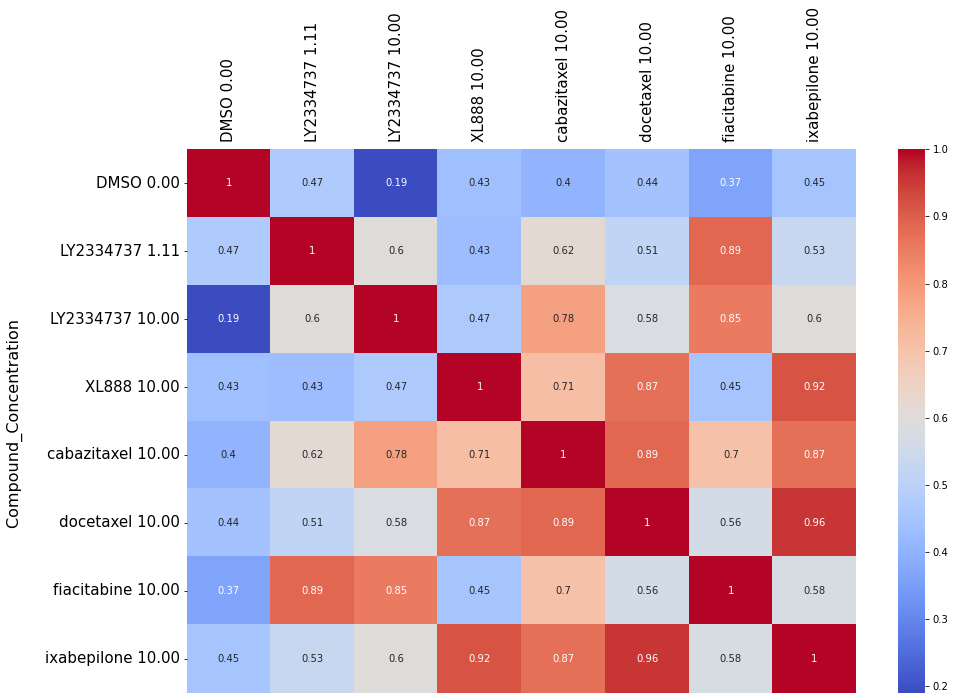

In [12]:
#@title Calculate correlations and plot similarity matrix
corr = corr_calculator(df_ag, strata = sort_by)
corr_fig = plot_corr(corr, fig_size = (15, 10))

In [ ]:
#@title Save correlations plot
fname = input("Give this figure a name:")
img_format = ".png"
corr_fig.figure.savefig(fname+img_format, dpi = 200,  bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:x


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **5.1 Add correlations to DataFrame**



*   To allow the correlation value to determine the order in which we plot the images, we must add correlation values to the DataFrame.

In [13]:
#@title Correlation based on which compound?

#@markdown * We need to select which compound/moa we want to have as a point of reference. 

#@markdown * Do you want to see how closely related are the treated cells to any of the compounds? Choose any compound you wish.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.00', 'XL888 10.00', 'ixabepilone 10.00', 'LY2334737 10.00', 'L…

In [14]:
#@title Save selected compound
corr_to = dropdown_output
print(corr_to)

DMSO 0.00


In [15]:
#@title Insert correlation values to the DataFrame based on your choice
insert_corr(df, corr, corr_to = corr_to, sort_by = sort_by)

{'DMSO 0.00': 1.0, 'LY2334737 1.11': 0.4748560808809973, 'LY2334737 10.00': 0.1905082869653239, 'XL888 10.00': 0.4347905992519112, 'cabazitaxel 10.00': 0.40355877884840774, 'docetaxel 10.00': 0.4441557267765934, 'fiacitabine 10.00': 0.3671674086291075, 'ixabepilone 10.00': 0.45008701056844147}


,Image_Metadata_Plate,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,Metadata_Well,Metadata_Concentration,Metadata_moa,Metadata_Compound,...,Nuclei_Texture_Variance_RNA_5_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,PathName_OrigMito,PathName_OrigAGP,PathName_OrigDNA,PathName_OrigRNA,PathName_OrigER,Metadata_Compound_Concentration,Correlation_to
0,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.143627,653.073964,32.750634,NaN,NaN,NaN,NaN,NaN,DMSO 0.00,1.00
1,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.346073,1979.191781,47.390839,NaN,NaN,NaN,NaN,NaN,DMSO 0.00,1.00
2,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.608686,2080.545903,48.469193,NaN,NaN,NaN,NaN,NaN,DMSO 0.00,1.00
3,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.182150,1120.825549,52.805403,NaN,NaN,NaN,NaN,NaN,DMSO 0.00,1.00
4,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.463527,1696.844459,78.116332,NaN,NaN,NaN,NaN,NaN,DMSO 0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,-0.815897,257.289705,2091.924182,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00,0.37
7573,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,0.657768,1040.821322,2097.956493,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00,0.37
7574,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,1.341672,1429.728495,2098.826344,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00,0.37
7575,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,0.099569,1743.008311,2110.983646,NaN,NaN,NaN,NaN,NaN,fiacitabine 10.00,0.37


## **5.2 What are the five compounds closer to the negative control?**

In [16]:
#@title Run dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [17]:
#@title Choose the negative control or the compound you want to see the most correlated to.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.00', 'XL888 10.00', 'ixabepilone 10.00', 'LY2334737 10.00', 'L…

In [18]:
#@title Save chosen compound
ctrl = dropdown_output
print(ctrl)

DMSO 0.00


In [19]:
#@title Display top five compounds closest to control
five_most_corr(df, corr, control = ctrl, sort_by = sort_by, add_moa = True)

Five compound most correlated to  DMSO 0.00


,Compound,Correlation,moa
0,LY2334737 1.11,0.474856,antitumor agent|ribonucleotide reductase inhib...
1,ixabepilone 10.00,0.450087,microtubule stabilizing agent
2,docetaxel 10.00,0.444156,tubulin polymerization inhibitor
3,XL888 10.00,0.434791,HSP inhibitor
4,cabazitaxel 10.00,0.403559,microtubule inhibitor


# **6. Visualize cells**



*   We can choose from one of the following methods to select the cells:
        random - generate n randomly selected cells
        representative - clusters the data and sample from the "closest to mean cluster"



In [20]:
#@title Choose the method to choose cells to plot:
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['random', 'representative']
dropdown(choose_cells)

Dropdown(description='Choose', options=('random', 'representative'), value='random')

In [21]:
#@title From the method selected above, select cells and save to a new DataFrame:
plot = dropdown_output
corr_input = input("Would you like to use the correlations to order your image plot? Type yes or no ")
corr_input_transform = stringToBool(corr_input)

if plot == 'random':
    df_selected_smp = random_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform)
elif plot == 'representative':
    df_selected_smp = representative_kmeans_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform)
elif plot == 'geometric_median':
    df_selected_smp = representative_median_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform)

Would you like to use the correlations to order your image plot? Type yes or no yes
How many cells would you like to plot for each group?1


In [22]:
#@title Add the image path to the selected DataFrame
df_plot = add_path(
                df_selected_smp, images_dir, channels = channels, 
                compressed = True, 
                compressed_format = 'png'
                  )

## **6.1 Plot cells**

* On the next code cell, you can customize depending on your preferences:
    - **label**: if label = True, you will see the labels on the left of each row.
    - **label_column** if you choose label = True, provide a string with the name of the column the user want to use as the label
    - **compressed**: specify if you're using a compressed version of your images to plot (i.e. they were acquired on tiff but you're using png images to plot)
    - **correlation**: if correlation = True, the order of images will consider the correlation calculated on the step above. 



In [23]:
#@title Rescale or not image intensity

#@markdown User should choose to visualize the images with rescaled intensity or not rescaled. 

rescale_input = input("Visualize images with rescaled intensity or not rescaled? Type yes or no ")
rescale_input_transf = stringToBool(corr_input)

Visualize images with rescaled intensity or not rescaled? Type yes or no yes


representative


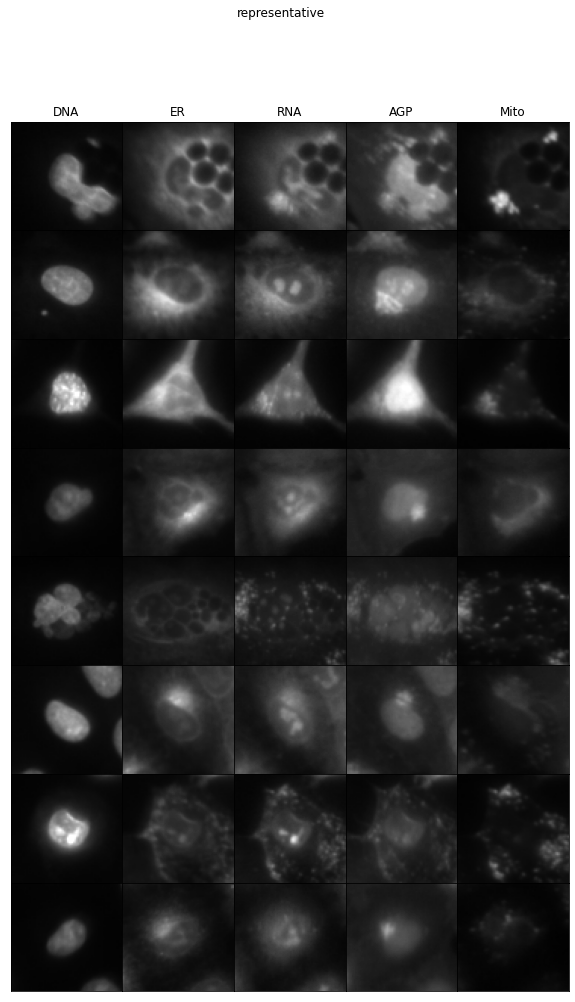

In [24]:
#@title Take a look at the images in a shuffled order, without the labels. 
#@markdown * Do you see any tendencies? Look at the nuclei size, intensity of the stains.

df_shuffle = df_plot.sample(frac=1).reset_index(drop=True)
fig_less_bias = visualize_n_SingleCell(channels,df_shuffle,box_size,title=plot,
compressed=True,compressed_im_size=1080,rescale=rescale_input_transf)

representative


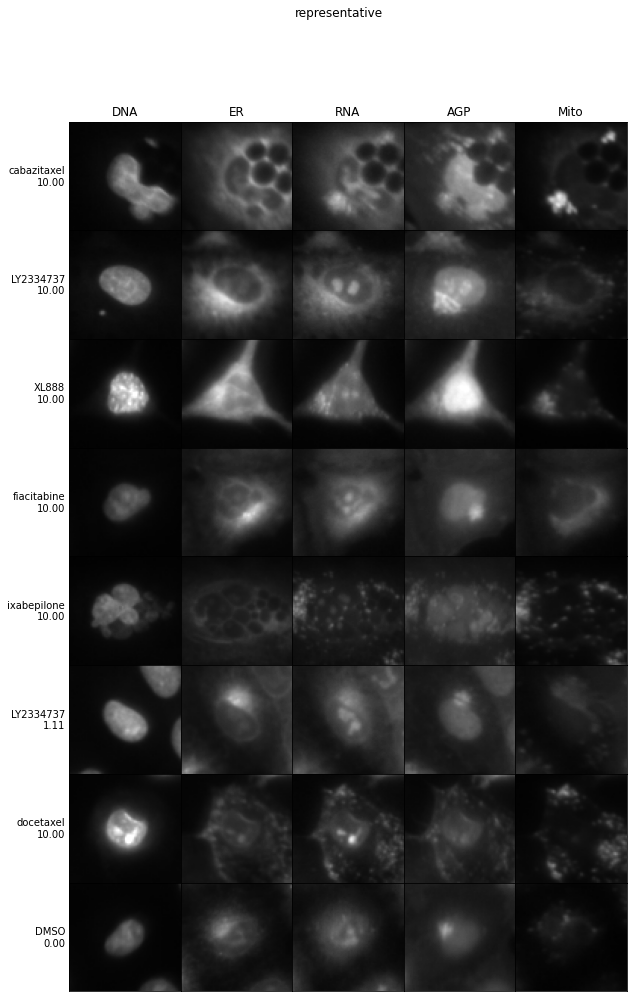

In [25]:
#@title Now look at the shuffled images with their labels. Can you think of any reasons why some cells are bigger, smaller?
fig_less_bias = visualize_n_SingleCell(channels,df_shuffle,box_size,title=plot,
compressed=True,compressed_im_size=1080, label=True, label_column=sort_by, rescale=rescale_input_transf)

representative


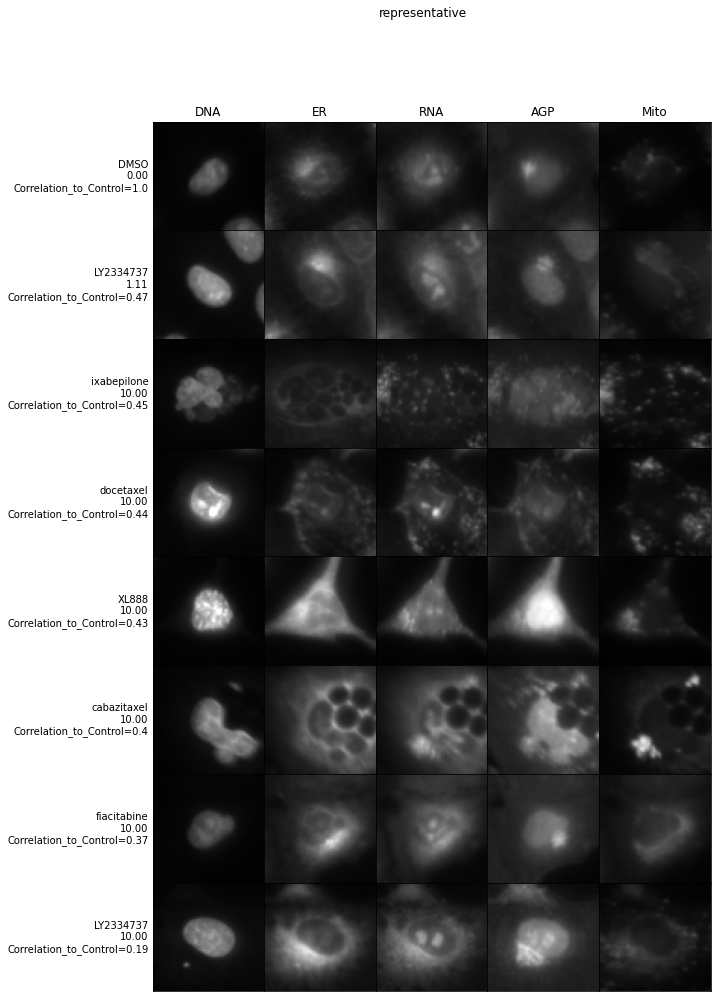

In [26]:
#@title Plot single-cells order by correlation
fig = visualize_n_SingleCell(channels,df_plot,box_size,label=True,label_column=sort_by,title=plot,
compressed=True,compressed_im_size=1080, correlation = True, rescale=rescale_input_transf)

In [ ]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
fig.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:rescaled_single


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **6.2 Plot representative images**

Imagine if you want to visualize the whole site where your representative cells is. Or you want to have a sense of the cell density/distribution within your sites.

representative


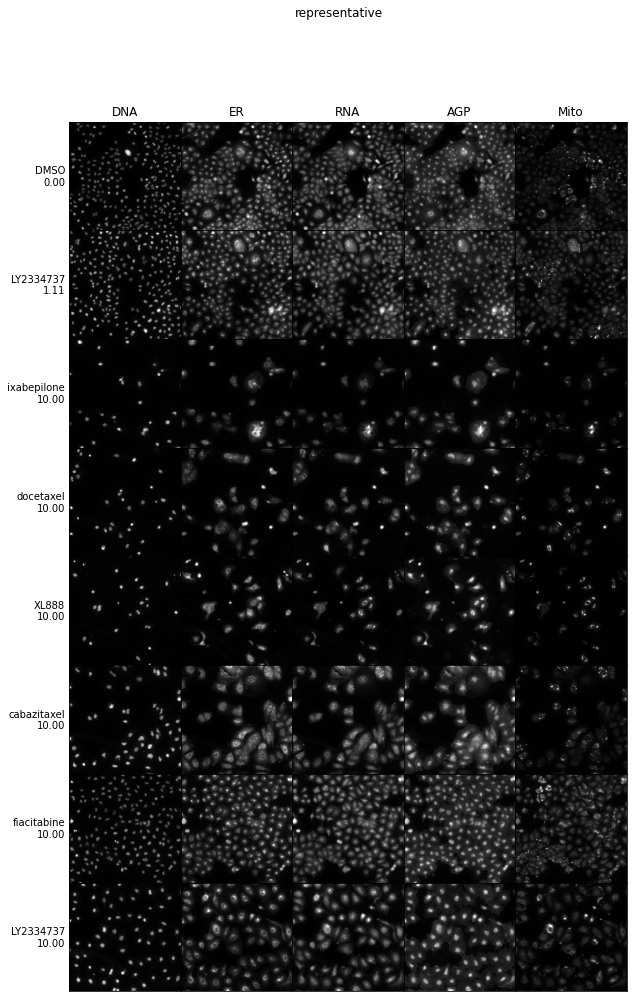

In [27]:
#@title Plot images
img = visualize_image(channels,df_plot,title=plot,label=True, label_column=sort_by,rescale=rescale_input_transf)

In [ ]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
img.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:rescaled_all


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>